In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the datasets
train_transaction = pd.read_csv('/content/drive/My Drive/ieee-fraud-detection/train_transaction.csv')
train_identity = pd.read_csv('/content/drive/MyDrive/ieee-fraud-detection/train_identity.csv')

# Merge the datasets on TransactionID
df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [ ]:
# Quick overview of the data
print("Shape of the merged dataset:", df.shape)
print("First few rows:")
print(df.head())

# Summary statistics
print("Summary statistics:")
print(df.describe())

Shape of the merged dataset: (590540, 434)
First few rows:
   TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id

In [ ]:
# Check for missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("Missing data statistics:")
print(missing_data.head(20))

Missing data statistics:
       Missing Values  Percentage
id_24          585793   99.196159
id_25          585408   99.130965
id_07          585385   99.127070
id_08          585385   99.127070
id_21          585381   99.126393
id_26          585377   99.125715
id_27          585371   99.124699
id_23          585371   99.124699
id_22          585371   99.124699
dist2          552913   93.628374
D7             551623   93.409930
id_18          545427   92.360721
D13            528588   89.509263
D14            528353   89.469469
D12            525823   89.041047
id_03          524216   88.768923
id_04          524216   88.768923
D6             517353   87.606767
id_33          517251   87.589494
id_10          515614   87.312290


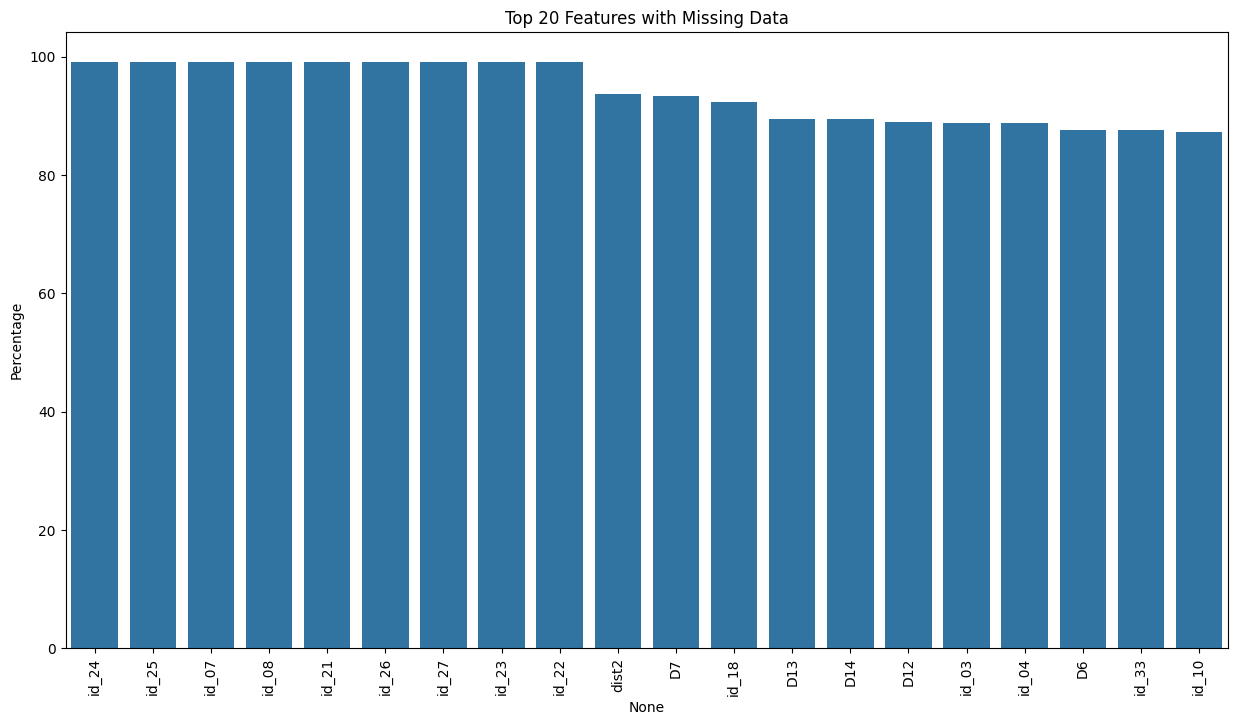

In [ ]:
# Visualize missing data
plt.figure(figsize=(15, 8))
sns.barplot(x=missing_data.index[:20], y=missing_data['Percentage'][:20])
plt.xticks(rotation=90)
plt.title('Top 20 Features with Missing Data')
plt.show()

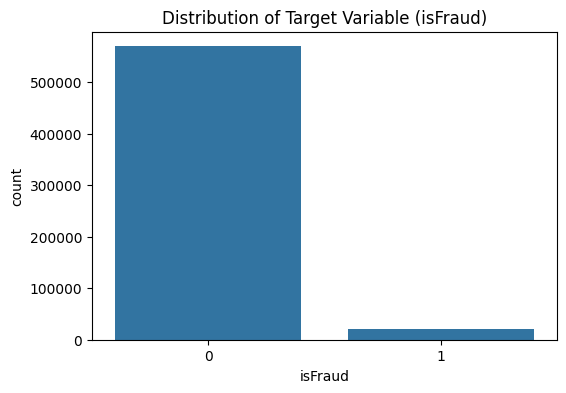

In [ ]:

# Target distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='isFraud', data=df)
plt.title('Distribution of Target Variable (isFraud)')
plt.show()

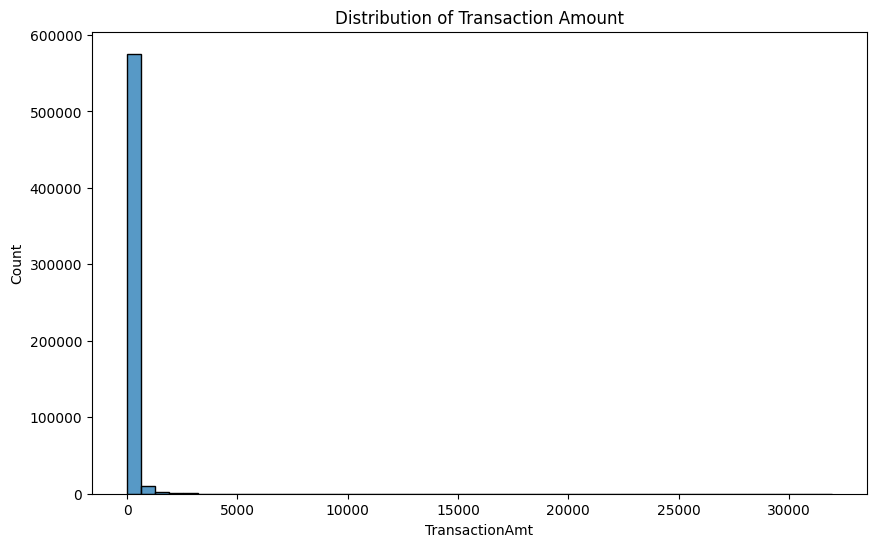

In [ ]:
# Analyze transaction amount
plt.figure(figsize=(10, 6))
sns.histplot(df['TransactionAmt'], bins=50, kde=False)
plt.title('Distribution of Transaction Amount')
plt.show()

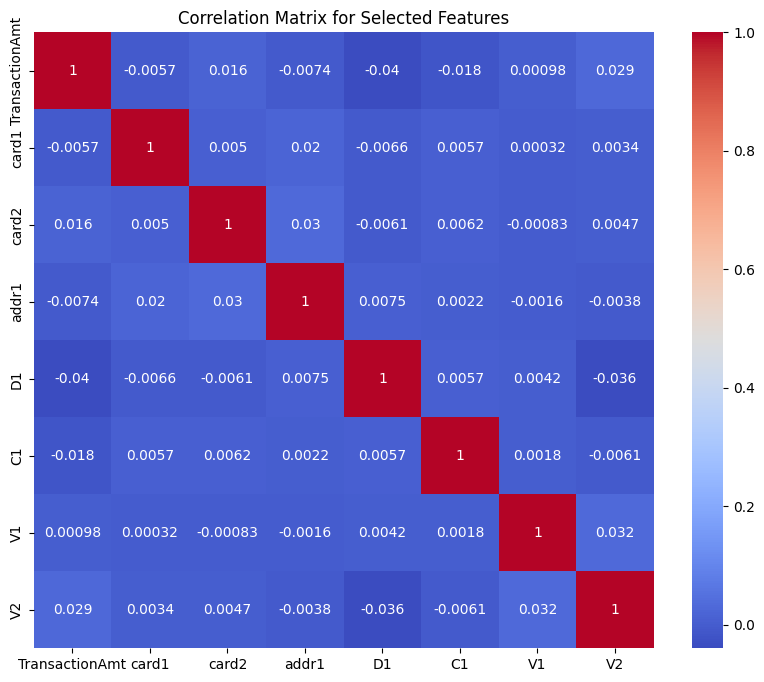

In [ ]:
# Correlation matrix (for the first few numerical features)
corr = df[['TransactionAmt', 'card1', 'card2', 'addr1', 'D1', 'C1', 'V1', 'V2']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Selected Features')
plt.show()

In [ ]:
# Preprocessing Steps
# Fill missing values (for simplicity, we fill with -999; this can be refined later)
df.fillna(-999, inplace=True)

# Encode categorical variables
categorical_cols = ['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'DeviceType']
df = pd.get_dummies(df, columns=categorical_cols)

# Prepare training data (features and target)
y = df['isFraud']  # Separate the target variable first
X = df.drop(['isFraud', 'TransactionID'], axis=1)  # Then, drop from features

# Feature scaling (only on numeric columns, excluding the target variable)
from sklearn.preprocessing import StandardScaler
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

In [ ]:
# proceed with the train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Save the preprocessed data
X_train.to_csv('/content/drive/My Drive/ieee-fraud-detection/X_train_preprocessed.csv', index=False)
X_test.to_csv('/content/drive/My Drive/ieee-fraud-detection/X_test_preprocessed.csv', index=False)
y_train.to_csv('/content/drive/My Drive/ieee-fraud-detection/y_train.csv', index=False)
y_test.to_csv('/content/drive/My Drive/ieee-fraud-detection/y_test.csv', index=False)

print("Preprocessing complete. Data saved to CSV files.")

Preprocessing complete. Data saved to CSV files.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Display the available columns
print("Available columns:", df.columns)

# Temporal Features
df['TransactionHour'] = (df['TransactionDT'] // 3600) % 24
df['TransactionDay'] = (df['TransactionDT'] // (3600 * 24)) % 7

# Log Transformation for Transaction Amount
df['TransactionAmt_Log'] = np.log1p(df['TransactionAmt'])

# Interaction Features - Using available features instead of ProductCD
if 'card1' in df.columns and 'addr1' in df.columns:
    df['addr1_card1'] = df['addr1'].astype(str) + '_' + df['card1'].astype(str)
    le = LabelEncoder()
    df['addr1_card1'] = le.fit_transform(df['addr1_card1'])

# Drop any original features that are now redundant or overly sparse
df = df.drop(['TransactionDT'], axis=1)

print("Feature engineering complete. Sample of the dataset:")
print(df.head())


Available columns: Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'R_emaildomain_yahoo.co.uk', 'R_emaildomain_yahoo.com',
       'R_emaildomain_yahoo.com.mx', 'R_emaildomain_yahoo.de',
       'R_emaildomain_yahoo.es', 'R_emaildomain_yahoo.fr',
       'R_emaildomain_ymail.com', 'DeviceType_-999', 'DeviceType_desktop',
       'DeviceType_mobile'],
      dtype='object', length=567)
Feature engineering complete. Sample of the dataset:
   TransactionID  isFraud  TransactionAmt  card1  card2  card3  card5  addr1  \
0        2987000        0            68.5  13926 -999.0  150.0  142.0  315.0   
1        2987001        0            29.0   2755  404.0  150.0  102.0  325.0   
2        2987002        0            59.0   4663  490.0  150.0  166.0  330.0   
3        2987003        0            50.0  18132  567.0  150.0  117.0  476.0   
4        2987004        0            50.0   4497  514.0  150.0 

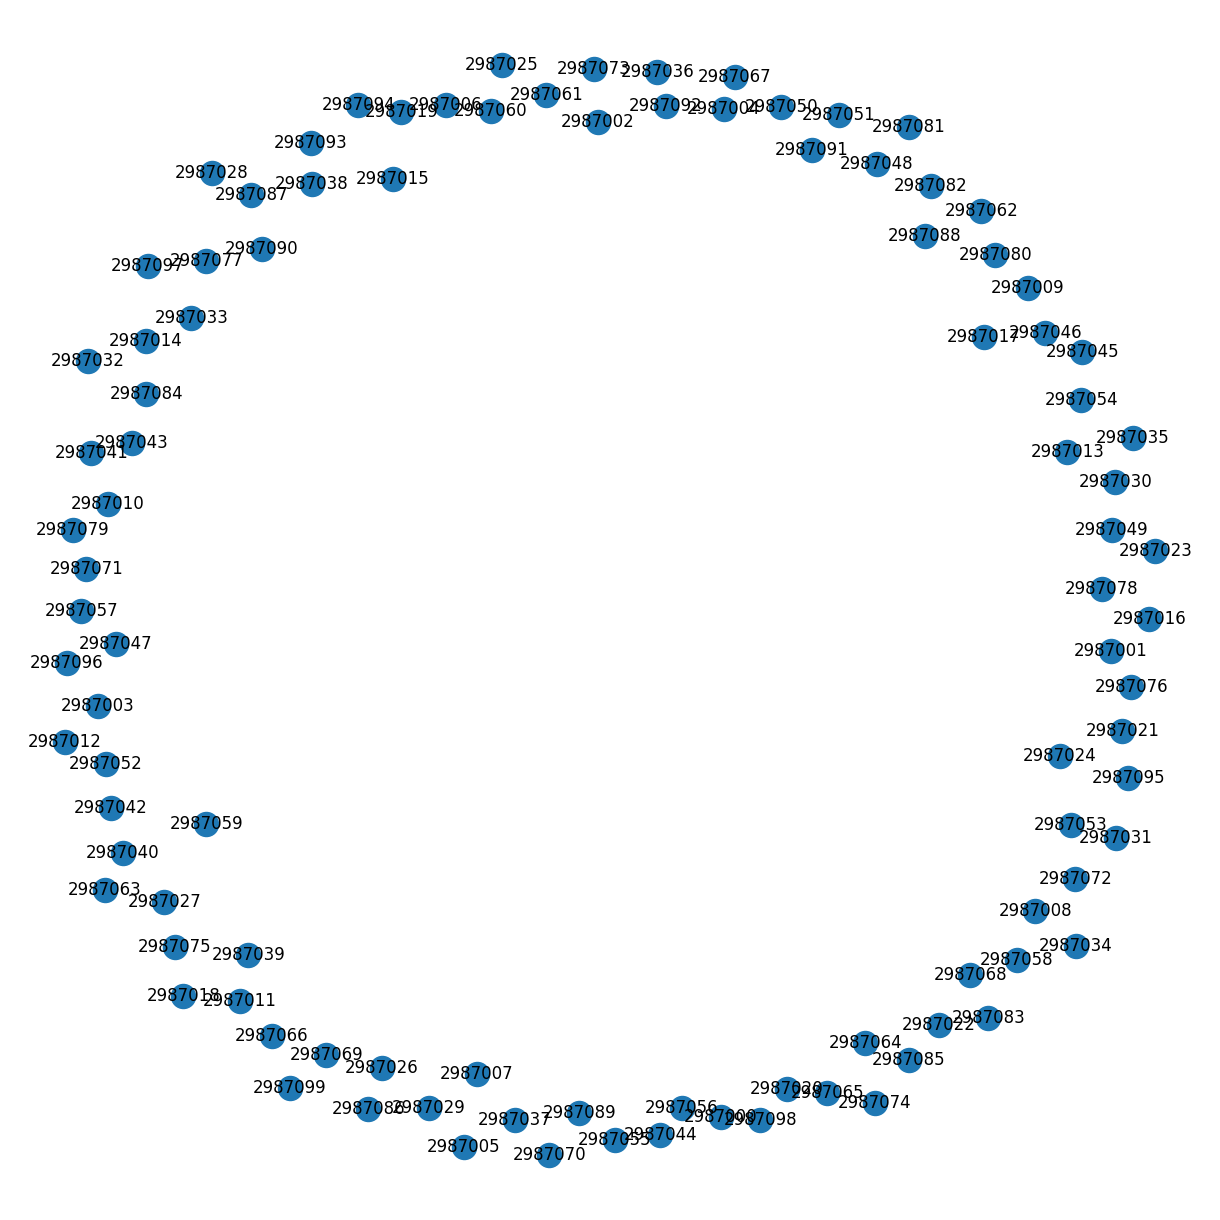

Graph construction complete. The graph has been saved as 'fraud_detection_graph.pkl'.


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pickle

# Initialize the graph
G = nx.Graph()

# Adding Nodes: Using the 'card1', 'addr1', and 'TransactionID' as nodes
if 'card1' in df.columns and 'addr1' in df.columns:
    cards = df['card1'].unique().tolist()
    addresses = df['addr1'].unique().tolist()
    transactions = df['TransactionID'].unique().tolist()

    G.add_nodes_from(cards, node_type='card')
    G.add_nodes_from(addresses, node_type='address')
    G.add_nodes_from(transactions, node_type='transaction')

    # Adding Edges based on the relationships between transactions, cards, and addresses
    for idx, row in df.iterrows():
        G.add_edge(row['TransactionID'], row['card1'], edge_type='transaction_card')
        G.add_edge(row['TransactionID'], row['addr1'], edge_type='transaction_address')

    # Optional: Visualize the Graph (for a small subset)
    subgraph = G.subgraph(transactions[:100])  # Taking a small subgraph for visualization
    plt.figure(figsize=(12, 12))
    nx.draw(subgraph, with_labels=True)
    plt.show()

    # Save the graph using pickle
    with open('/content/drive/My Drive/ieee-fraud-detection/fraud_detection_graph.pkl', 'wb') as f:
        pickle.dump(G, f)

    print("Graph construction complete. The graph has been saved as 'fraud_detection_graph.pkl'.")
else:
    print("Required columns for graph construction are missing.")


In [ ]:
# Checking unique values in the target variable
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))

Unique values in y_train: [0 1]
Unique values in y_test: [0 1]


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Check the unique values in the id_31 column
print("Unique values in id_31 column:", X_train['id_31'].unique())


Unique values in id_31 column: [  0  46  43  44  56  88  98  49  95  55  94 120  52  61  69 113  21  18
  78  54  79  53  50  66  80  68  85  47 101  42  28  89  57  37  19 102
 121  62 111 110  32  99  38  30  12  22 125  72 118  84  97  74 105  77
  16  75   3  39 106  24  41  67 123   8  81  20  40  45 100  13 119  23
  36 112  48  93  26  82   2 104  15 122  35  65 116 108  73 114  96  33
  87  51  31  27  25  70  34 103  29  76  63  83   9 117   5  92  58  14
  17  86  71  60 115  91  10 109   6  59 126 124  90   1  64 107   4  11
   7]


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Custom function to fit the LabelEncoder and handle unseen labels in the test set
def fit_transform_label_encoder(train, test, col_name):
    le = LabelEncoder()
    le.fit(train[col_name].astype(str))
    train[col_name] = le.transform(train[col_name].astype(str))
    test[col_name] = test[col_name].map(lambda s: '<UNK>' if s not in le.classes_ else s)
    le.classes_ = np.append(le.classes_, '<UNK>')
    test[col_name] = le.transform(test[col_name].astype(str))
    return train, test

# Apply to id_31 and other relevant categorical columns
X_train, X_test = fit_transform_label_encoder(X_train, X_test, 'id_31')

# Double-check for any remaining object columns
object_cols = X_train.select_dtypes(include=['object']).columns
if len(object_cols) > 0:
    print("Remaining object columns after encoding:", object_cols)
else:
    print("All columns are now numeric.")

# Now try fitting the XGBoost model again
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report

# Define the XGBoost model with categorical handling enabled
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='auc',
    tree_method='hist',  # Use histogram-based method
    device='cuda',       # Enable GPU acceleration
    enable_categorical=False  # Ensure no categorical types are directly passed
)

# Fit the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("XGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb)}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb)}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob_xgb)}")
print(classification_report(y_test, y_pred_xgb))

# Save the model
xgb_model.save_model('/content/drive/My Drive/ieee-fraud-detection/xgb_model.json')


All columns are now numeric.


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:03:11] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Model Evaluation:
Accuracy: 0.9816862532597284
F1 Score: 0.6763429597486159
ROC-AUC: 0.950952747314347
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.93      0.53      0.68      4242

    accuracy                           0.98    118108
   macro avg       0.95      0.77      0.83    118108
weighted avg       0.98      0.98      0.98    118108



In [ ]:
import pandas as pd
import numpy as np

# Convert boolean columns to integers
for col in X_train.select_dtypes(include=['bool']).columns:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

# Check for any remaining object types and convert to strings or numeric as appropriate
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype(str)  # Ensure it's a string first
    X_test[col] = X_test[col].astype(str)

# Ensure all object columns are properly encoded as numeric
for col in X_train.columns:
    if X_train[col].dtype == 'object':
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Replace any remaining NaNs (if any) with 0
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

# Verify that all columns are now numeric
print(X_train.dtypes.value_counts())

# Convert the processed data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define the neural network architecture
class FraudDetectionNN(nn.Module):
    def __init__(self, input_dim):
        super(FraudDetectionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc4(x))
        return x

# Initialize the model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
model = FraudDetectionNN(input_dim).cuda()  # Move model to GPU

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader)}')

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_prob_nn = model(X_test_tensor.cuda()).cpu().numpy()
    y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)

print("Deep Neural Network Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_nn)}")
print(f"F1 Score: {f1_score(y_test, y_pred_nn)}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob_nn)}")
print(classification_report(y_test, y_pred_nn))

# Save the model
torch.save(model.state_dict(), '/content/drive/My Drive/ieee-fraud-detection/fraud_detection_nn.pth')


float64    401
int64      164
Name: count, dtype: int64
Epoch 1/50, Loss: 0.13554082352913305
Epoch 2/50, Loss: 0.12493154918276625
Epoch 3/50, Loss: 0.12120295057224124
Epoch 4/50, Loss: 0.11988184590092466
Epoch 5/50, Loss: 0.1181742744049725
Epoch 6/50, Loss: 0.11663194254544859
Epoch 7/50, Loss: 0.11570811441644574
Epoch 8/50, Loss: 0.11552458227592145
Epoch 9/50, Loss: 0.11464358533893322
Epoch 10/50, Loss: 0.11496591235255402
Epoch 11/50, Loss: 0.11541836513158421
Epoch 12/50, Loss: 0.116793669058392
Epoch 13/50, Loss: 0.11656624119260997
Epoch 14/50, Loss: 0.1172502306771907
Epoch 15/50, Loss: 0.11618267315490596
Epoch 16/50, Loss: 0.12019645191254198
Epoch 17/50, Loss: 0.1160668720422094
Epoch 18/50, Loss: 0.11586109626623423
Epoch 19/50, Loss: 0.11592765673462617
Epoch 20/50, Loss: 0.11997221188117106
Epoch 21/50, Loss: 0.12213855670094874
Epoch 22/50, Loss: 0.12350039694428472
Epoch 23/50, Loss: 0.1298608987834895
Epoch 24/50, Loss: 0.12819701055404423
Epoch 25/50, Loss: 0.12